# TD4-IntroProjet : Insuline-Glucose-Diabète

L’objectif est d’étudier la régulation de la glycémie (concentration de glucose dans le sang). Cette régulation est effectuée par une hormone : l’insuline. Lorsque la glycémie augmente, les cellules β du pancréas relâche cette hormone qui permet de faire rentrer le glucose dans les cellules – diminuant le glucose dans le sang. Le diabète est une maladie de la dérégulation du contrôle de la glycémie. Sa prévalence est en constante augmentation dans le monde.

Ce TP est en 2 parties :
1. vous allez développer un modèle minimal Glucose/Insuline dans le sang avec des données de la littérature.
2. vous allez développer un modèle de mise en place du diabète.

### 1 Insuline/Glucose après injection en intraveineuse

Vous allez étudier la dynamique insuline/glucose lors d’une injection d’un bolus de glucose en intraveineuse (IV). Dans un test de tolérance au glucose en IV, un individu est prélevé à intervalle régulier pour tester la glycémie après une injection de glucose en IV. On suppose que la personne était à jeun. Les échantillons sanguins sont analysés et le glucose et l’insuline sont dosés.
Des données typiques d’un individu se trouvent dans le fichier IG 1.txt (sur Moodle) : en colonne Temps (minute), Glucose (mg/dl), Insuline (mU/ml).


#### 1.1 Le modèle

Développer un modèle général de régulation Glucose - Insuline. On commence par un modèle de 2 variables, la concentration de glucose et la concentration d’insuline dans le sang. Nous allons faire les hypothèses suivantes :
— L’insuline est produite en fonction du glucose et se dégrade normalement
— Le glucose diminue dans le sang en proportion de l’insuline
— Il y a toujours des canaux pour le glucose (GLUT1) notamment dans le cerveau qui n’est pas insulino-sensible. Donc le glucose diminue régulièrement pour atteindre un niveau basal qui est pour l’humain autour de Gb = 100mg/dl
— On suppose que l’injection a lieu à t = 0 donc le glucose de départ sera celui injecté en intraveineuse

Etapes de construction du modèle :
1. Charger les données et les visualiser. Qu’en pensez vous ? Comment obtenir la quantité injectée en IV à t = 0 ?

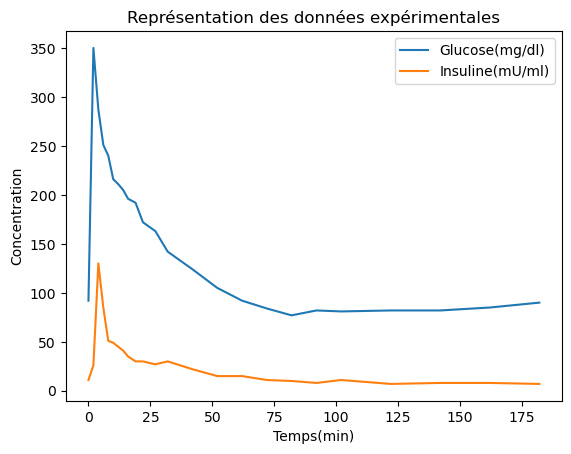

In [20]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fmin
import matplotlib.pyplot as plt

ig = np.loadtxt('IG_1.txt',dtype=int).T

plt.plot(ig[0],ig[1],label="Glucose(mg/dl)")
plt.plot(ig[0],ig[2],label="Insuline(mU/ml)")

plt.title("Représentation des données expérimentales")
plt.xlabel('Temps(min)')
plt.ylabel('Concentration')
plt.legend()
plt.show()

tgT = ig.T
igT = tgT[1:,0]-2

On a deux courbes dont l'orange corresond à l'insuline et le bleu au glucose. On observe un pic de glucose à 350 mg/dl après l'injection (à t=2) et en même temps il y a un pic d'insulie au temps suivant (t=4) a 130  mU/ml  Le taux d'insuline devient progressivement nul et le taux de glucose tend vers son niveau basal qui vaut 100 mg/dl. On a une représentation de la régulation du glucose par l'insuline. Pour avoir la quantité injectée en IV à t=0, on calcule la différence de concentration entre le pic et le temps avant le pic. Ici on serait a Glu(t=2) - Glu(t=0) = 350 - 92 = 258 mg/dl.

2. Développer un premier modèle le plus simple : glucose/insuline avec pour chaque équation une entrée et une sortie (et 4 paramètres). Il est possible d’utiliser des ’seuils’ ; par exemple max(0, Gb − G) vaudra zéro si le glucose (G) est au dessus de Gb et vaudra Gb − G sinon. Ecrire les équations, et résoudre numériquement. Attention au choix des conditions initiales.

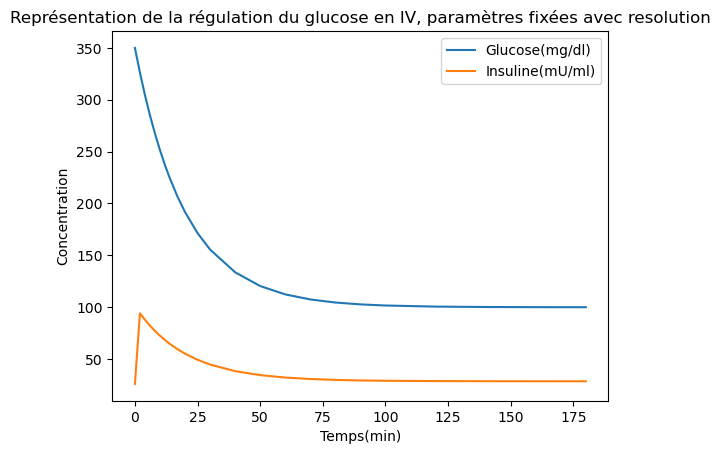

In [22]:
def igmodel(y,t,a,b,c,d,Gb):
    G = y[0]
    I = y[1]
    dgdt = -a*I*G - b*max(0,G-Gb)
    didt = c*G-d*I
    return dgdt,didt

y0 = [350,26]
t = igT
a= 1e-6
b= 0.05
c= 1
d= 3.5
Gb = 100

igP =  odeint(igmodel,y0,t,args=(a,b,c,d,Gb)).T

plt.title("Représentation de la régulation du glucose en IV, paramètres fixées avec resolution")
plt.plot(t,igP[0],label="Glucose(mg/dl)")
plt.plot(t,igP[1],label="Insuline(mU/ml)")

plt.xlabel('Temps(min)')
plt.ylabel('Concentration')
plt.legend()
plt.show()

3. Comparer ce modèle et les données en manipulant les paramètres. Le plus simple est de commencer par des valeurs de paramètres petites et des paramètres de couplages nuls (couplage=partie de l’´equation qui relie les deux variables).

In [3]:
##Paramètres finaux choisis

y0 = [350,26]
t = igT
a= 1e-4
b= 0.05
c= 1
d= 5
Gb = 100

test = np.delete(np.delete(ig,0,0).T,0,0)

4. Ajuster le modèle en estimant les paramètres en minimisant une distance. Il faut déterminer la meilleur distance pour ajuster à la fois le glucose et l’insuline. rmq : comme on suppose que l’injection à lieu à t = 0 il faut penser à le prendre en compte dans les données.

In [4]:
def distance(param,obs,t,y0):
    a,b,c,d= param
    Gb = 100
    P = odeint(igmodel,y0,t,args=(a,b,c,d,Gb))
    d =  np.sum((P-obs)**2)
    return d + 1e8*(a<0) + 1e8*(b<0) +1e8*(c<0)+1e8*(d<0)

igt0 = np.delete(ig[0],0)
igt1 = np.delete(ig[1],0)
igt2 = np.delete(ig[2],0)
param = [a,b,c,d]
p = fmin(distance,param,args=(test,igt0,y0))
print(p)



Optimization terminated successfully.
         Current function value: 10687.850704
         Iterations: 162
         Function evaluations: 291
[1.47794535e-04 6.00403932e-02 9.71499703e-01 4.12973302e+00]


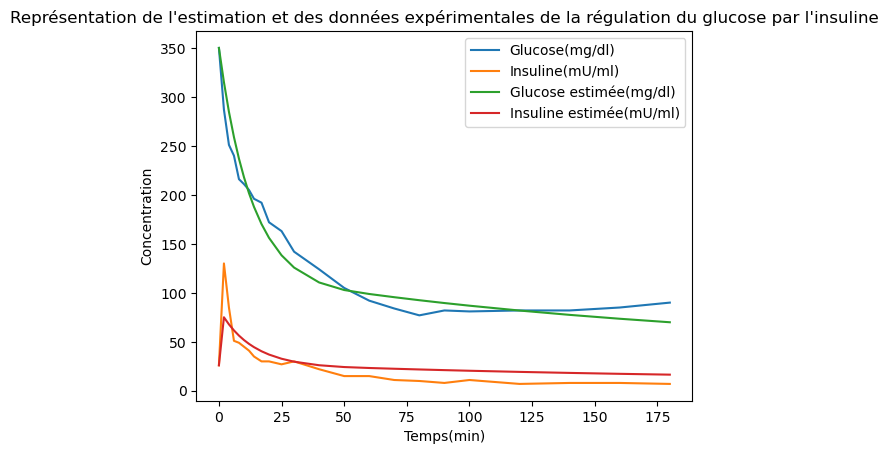

In [23]:
Pestim = odeint(igmodel,y0,t,args=(p[0],p[1],p[2],p[3],Gb)).T

plt.title("Représentation de l'estimation et des données expérimentales de la régulation du glucose par l'insuline")
plt.plot(igT,igt1,label="Glucose(mg/dl)")
plt.plot(igT,igt2,label="Insuline(mU/ml)")
plt.plot(t,Pestim[0],label="Glucose estimée(mg/dl)")
plt.plot(t,Pestim[1],label="Insuline estimée(mU/ml)")


plt.xlabel('Temps(min)')
plt.ylabel('Concentration')
plt.legend()
plt.show()

#### 1.2 (pour aller plus loin) Modèle avancé

Une manière d’améliorer ce premier modèle est d’introduire une dépendance non
linéaire de production d’insuline par le glucose :
— Commencer par exemple par un carré et essayer d’ajuster les données. Qu’en pensez vous ?
— Etendre à un paramètre n de puissance qui peut-être ajusté lui aussi.


[7.12171789e-07 7.50400428e-02 4.72842133e-03 1.06294348e+01
 2.15776320e+00]


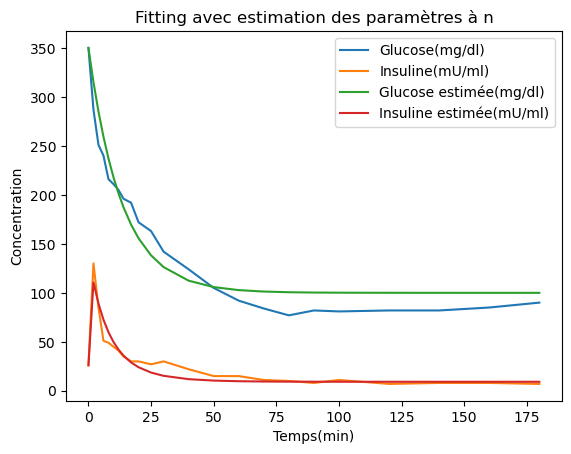

In [26]:
def igmodeln(y,t,a,b,c,d,Gb,n):
    G = y[0]
    I = y[1]
    dgdt = -a*I*G - b*max(0,G-Gb)
    didt = c*(G**n)-d*I
    return dgdt,didt

y0 = [350,26]
t = igT
a= 1e-6
b= 0.05
c= 1
d= 3.5
n=2
Gb = 100

igPn =  odeint(igmodeln,y0,t,args=(a,b,c,d,Gb,n,)).T


def distance_n(param,obs,t,y0):
    a,b,c,d,n= param
    Gb = 100
    P = odeint(igmodeln,y0,t,args=(a,b,c,d,Gb,n,))
    d =  np.sum((P-obs)**2)
    return d + 1e8*(a<0) + 1e8*(b<0) +1e8*(c<0)+1e8*(d<0) + +1e8*(n<0)

tn = igT
param_n = [a,b,c,d,n]
pn = fmin(distance_n,param_n,args=(test,igt0,y0))
print(pn)
Pnestim = odeint(igmodeln,y0,tn,args=(pn[0],pn[1],pn[2],pn[3],Gb,pn[4])).T

plt.title("Fitting avec estimation des paramètres à n")
plt.plot(igT,igt1,label="Glucose(mg/dl)")
plt.plot(igT,igt2,label="Insuline(mU/ml)")
plt.plot(tn,Pnestim[0],label="Glucose estimée(mg/dl)")
plt.plot(tn,Pnestim[1],label="Insuline estimée(mU/ml)")

plt.xlabel('Temps(min)')
plt.ylabel('Concentration')
plt.legend()
plt.show()

### 2 Modèle de mise en place du diabète

L’origine (du moins pour un certain type de cas) du diabète provient d’une perte de sensibilité des cellules à l’insuline. Cette perte de sensibilité entraîne une augmentation de la production d’insuline pour compenser. Parallèlement, l’augmentation du glucose dans le sang enclenche la prolifération des cellules β qui compense un temps l’augmentation du glucose. Cette prolifération s’arrête et s’inverse lorsque la concentration de glucose
devient encore trop importante entraînant le diabète : perte de la fonction pancréatique destruction des cellules β) et augmentation de la glycémie.

##### 2.1 Un modèle de diabète

On va considérer un modèle à 3 variables : la concentration de glucose (G), concentration d’insuline (I) et le nombre de cellules β pancréatique (B). Nous ferons les hypothèses suivantes :
1. La variation de glucose comprend un terme de production constant (G0) qui correspond à l’apport moyen de sucre via l’alimentation.
2. L’action de l’insuline se fera en modifiant la vitesse de d´egradation du glucose via un paramètre S qu’on appellera sensibilité.
3. La production d’insuline sera proportionnelle au glucose (linéaire ou non : G2 ou G2/G2+κ) et aux cellules β.
4. L’insuline se d´egrade normalement.
5. En culture, les cellules β prolifèrent (comme les pathogènes) en présence de glucose mais meurent en présence de trop de glucose (par exemple utiliser un terme en fonction du carr´e de la concentration pour le taux d’accroissement). On supposera que le glucose sert de substrat aux cellules β donc on ne modélise pas de capacité de charge.
6. les cellules β produisent toutes la même quantité d’insuline.
Ecrire le modèle – schéma et équations différentielles associées.


In [28]:
def dbmodel(y,t,a,b,c,d,e,f,S,G0,Gb):
    G = y[0]
    I = y[1]
    B = y[2]
    dGdt = -S*I*G + G0 - f*max(0,G-Gb)
    dIdt = a*(G**2)*B - b*I  
    dBdt = (c*G-d*(G**2)-e)*B
    return dGdt,dIdt,dBdt

##### 2.2 Première Analyse

Commencer par résoudre numériquement votre et modèle et étudier le comportement
avec des paramètres ’jouets’. Ensuite, étudier dans votre modèle le glucose à l’équilibre (et la prolifération – ou pas – des cellules β) en fonction de :

1. l’impact de l’apport en glucose (faire varier G0)
2. la sensibilité à l’insuline (faire varier S)


Puis, répondez à ces questions :
1. A quel état correspond le diabète dans votre modèle ?
2. Est-il possible de l’atteindre (i.e est-il stable) ?
3. Si oui comment ?

Vous pouvez essayer de retrouver les r´esultats de l’article de Topp et al. J. theor. Biol.(2000) (article disponible dans moodle). Dans ce papier les états stationnaires et leur dépendance en les parametres sont étudiés.


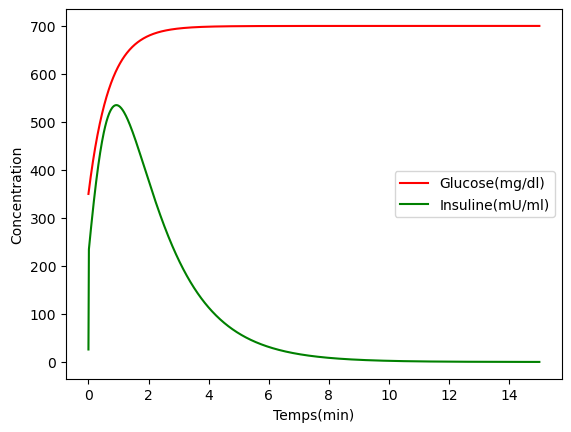

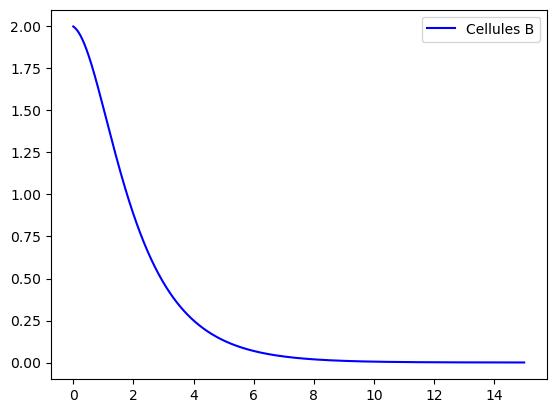

In [48]:
y0 = [350,26,2]
t = np.linspace(0,15,1000)

#a = sigma
a= 0.4
#b = k
b= 432
# c = r1
c= 0.84*1e-3
#d = r2
d= 0.24*1e-5
#e = d0
e= 0.06
#S = SI
S = 5*1e-6
#G0 =EG0
G0 = 864
#f = EG0
f = 1.44

dP =  odeint(dbmodel,y0,t,args=(a,b,c,d,e,f,S,G0,Gb)).T

plt.plot(t,dP[0],label="Glucose(mg/dl)",color="red")
plt.plot(t,dP[1],label="Insuline(mU/ml)",color="green")


plt.xlabel('Temps(min)')
plt.ylabel('Concentration')
plt.legend()
plt.show()

plt.plot(t,dP[2],label="Cellules B",color="blue")
plt.legend()
plt.show()

Le diabète dans le modèle correspond à la siutation ou la sensibilité à l'insuline est très élevée. Lorsque les cellules beta sont élevées, le taux d'insuline augmente et provoque un pic  qui est censé diminuer le taux de glucose. Or au fur et à mesure, on à le taux de cellules bêta qui tend vers un état statio vers 0. Donc le taux d'insuline diminue et tend progressivement vers 0 et le taux de glucose tend vers 700, c'est à dire G0/f + Gb >>G0.

##### 2.3 Insulino-résistance


Afin d’enrichir le modèle, on introduit une évolution temporelle (lente) de la sensibilité
sous la forme d’une dégradation de la sensibilité (de type exponentielle). Cette évolution
traduit une (lente) dégradation de la sensibilité au cours du temps.
1. Ecrire cette modification du modèle précédent.

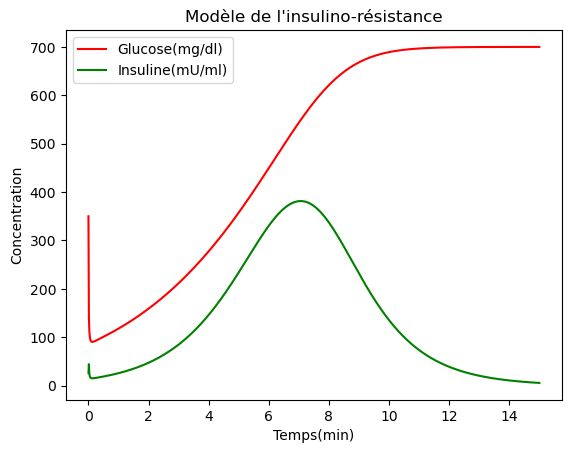

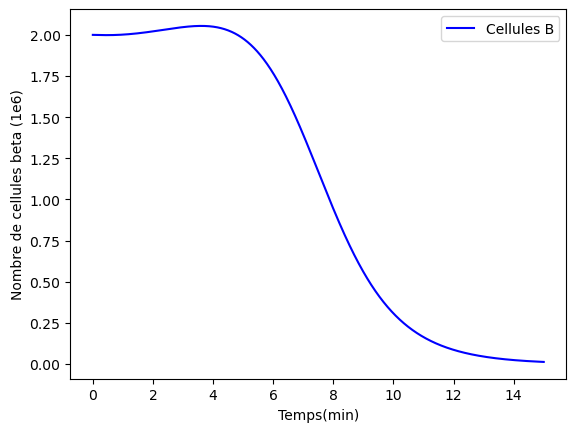

In [56]:
def dbirmodel(y,t,a,b,c,d,e,f,S,G0,Gb):
    G = y[0]
    I = y[1]
    B = y[2]
    dGdt = G0-S*np.exp(-t)*I*G-f*max(0,G-Gb)
    dIdt = a*(G**2)*B - b*I  
    dBdt = (c*G-d*(G**2)-e)*B
    return dGdt,dIdt,dBdt

S = 0.72
t = np.linspace(0,15,1000)
dPir =  odeint(dbirmodel,y0,t,args=(a,b,c,d,e,f,S,G0,Gb,)).T

plt.plot(t,dPir[0],label="Glucose(mg/dl)",color="red")
plt.plot(t,dPir[1],label="Insuline(mU/ml)",color="green")
plt.title("Modèle de l'insulino-résistance")
plt.xlabel('Temps(min)')
plt.ylabel('Concentration')
plt.legend()
plt.show()

plt.plot(t,dPir[2],label="Cellules B",color="blue")
plt.xlabel('Temps(min)')
plt.ylabel('Nombre de cellules beta (1e6)')
plt.legend()
plt.show()

